# Idle States Residency Analysis

In [150]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-16 14:50:53,104 INFO    : root         : Using LISA logging configuration:
2018-05-16 14:50:53,105 INFO    : root         :   /home/leoy/Work2/Develop/tools/lisa/logging.conf


In [151]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to access cpuidle information from the target
from devlib import *

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace
from trace import ResidencyTime, ResidencyData

# DataFrame support
import pandas as pd
from pandas import DataFrame

# Trappy (plots) support
from trappy import ILinePlot
from trappy.stats.grammar import Parser

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [152]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'generic_linux',
    "board"        : 'hikey',
    
    # Folder where all the results will be collected
    "results_dir" : "taskset_test",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',
        'cpuidle'
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench'],
}

In [153]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            280000,
            432000,
            729000,
            960000,
            1200000
        ],
        'little': [
            280000,
            432000,
            729000,
            960000,
            1200000
        ]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

# Plot for idle state statistics comparison

In [154]:
def plotCPUIdleStateResidencyComparison(prev_ia, post_ia, cpus=None, pct=False):
    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if cpus is None:
        # Generate plots only for available CPUs
        cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
        _cpus = range(cpuidle_data.cpu_id.max() + 1)
    else:
        _cpus = listify(cpus)
    
    # print _cpus
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    #print prev_residencies[0]
    #print post_residencies[0]
    
    n_plots = len(prev_residencies) + len(post_residencies)
    gs = gridspec.GridSpec(n_plots, 1)
    fig = plt.figure()

    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        
        #print prev_r
        #print post_r
        
        if prev_r is None:
            plt.close(fig)
            return
        
        if post_r is None:
            plt.close(fig)
            return
        
        is_first = idx == 0
        is_last  = (idx + 2) == n_plots
            
        axes = fig.add_subplot(gs[idx])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = prev_r.time.sum()
            r_pct = prev_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            prev_r.plot.barh(ax=axes, color='b',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": Before Optimization")

        axes.grid(True)
        axes.set_xticklabels([])

        if is_first:
            legend_y = axes.get_ylim()[1]
            axes.annotate('Idle State Residency Time Comparison', xy=(0, legend_y),
                              xytext=(-50, 45), textcoords='offset points',
                              fontsize=18)
            
        axes = fig.add_subplot(gs[idx+1])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = post_r.time.sum()
            r_pct = post_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            post_r.plot.barh(ax=axes, color='g',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": After Optimization")

        axes.grid(True)
        if is_last:
            if pct:
                axes.set_xlabel('Residency [%]')
            else:
                axes.set_xlabel('Time [s]')
        else:
            axes.set_xticklabels([])

# Calculate idle state statistics difference

In [155]:
def dfCPUIdleStateResidencyComparison(prev_ia, post_ia):
    df = pd.DataFrame(columns=('index', 'state0', 'state1', 'state2'))

    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    # Generate plots only for available CPUs
    cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
    _cpus = range(cpuidle_data.cpu_id.max() + 1)
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        diff_r = post_r - prev_r
        
        df = df.append({'index': data.label+"(orig)", 'state0': prev_r['time'][0],
                        'state1': prev_r['time'][1], 'state2': prev_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(opt)", 'state0': post_r['time'][0],
                        'state1': post_r['time'][1], 'state2': post_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(delta)", 'state0': diff_r['time'][0],
                        'state1': diff_r['time'][1], 'state2': diff_r['time'][2]}, ignore_index=True)            
    return df

# Idle state statistics and comparison for power nightmare case

## Read trace data before optimization

In [156]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/powernightmare/pre_opt'
trace_file = os.path.join(res_dir, "trace.dat")

In [157]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [158]:
prev_ia = trace.analysis.idle

## Read trace data after optimization

In [159]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/powernightmare/post_opt'
trace_file = os.path.join(res_dir, "trace.dat")

In [160]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [161]:
post_ia = trace.analysis.idle

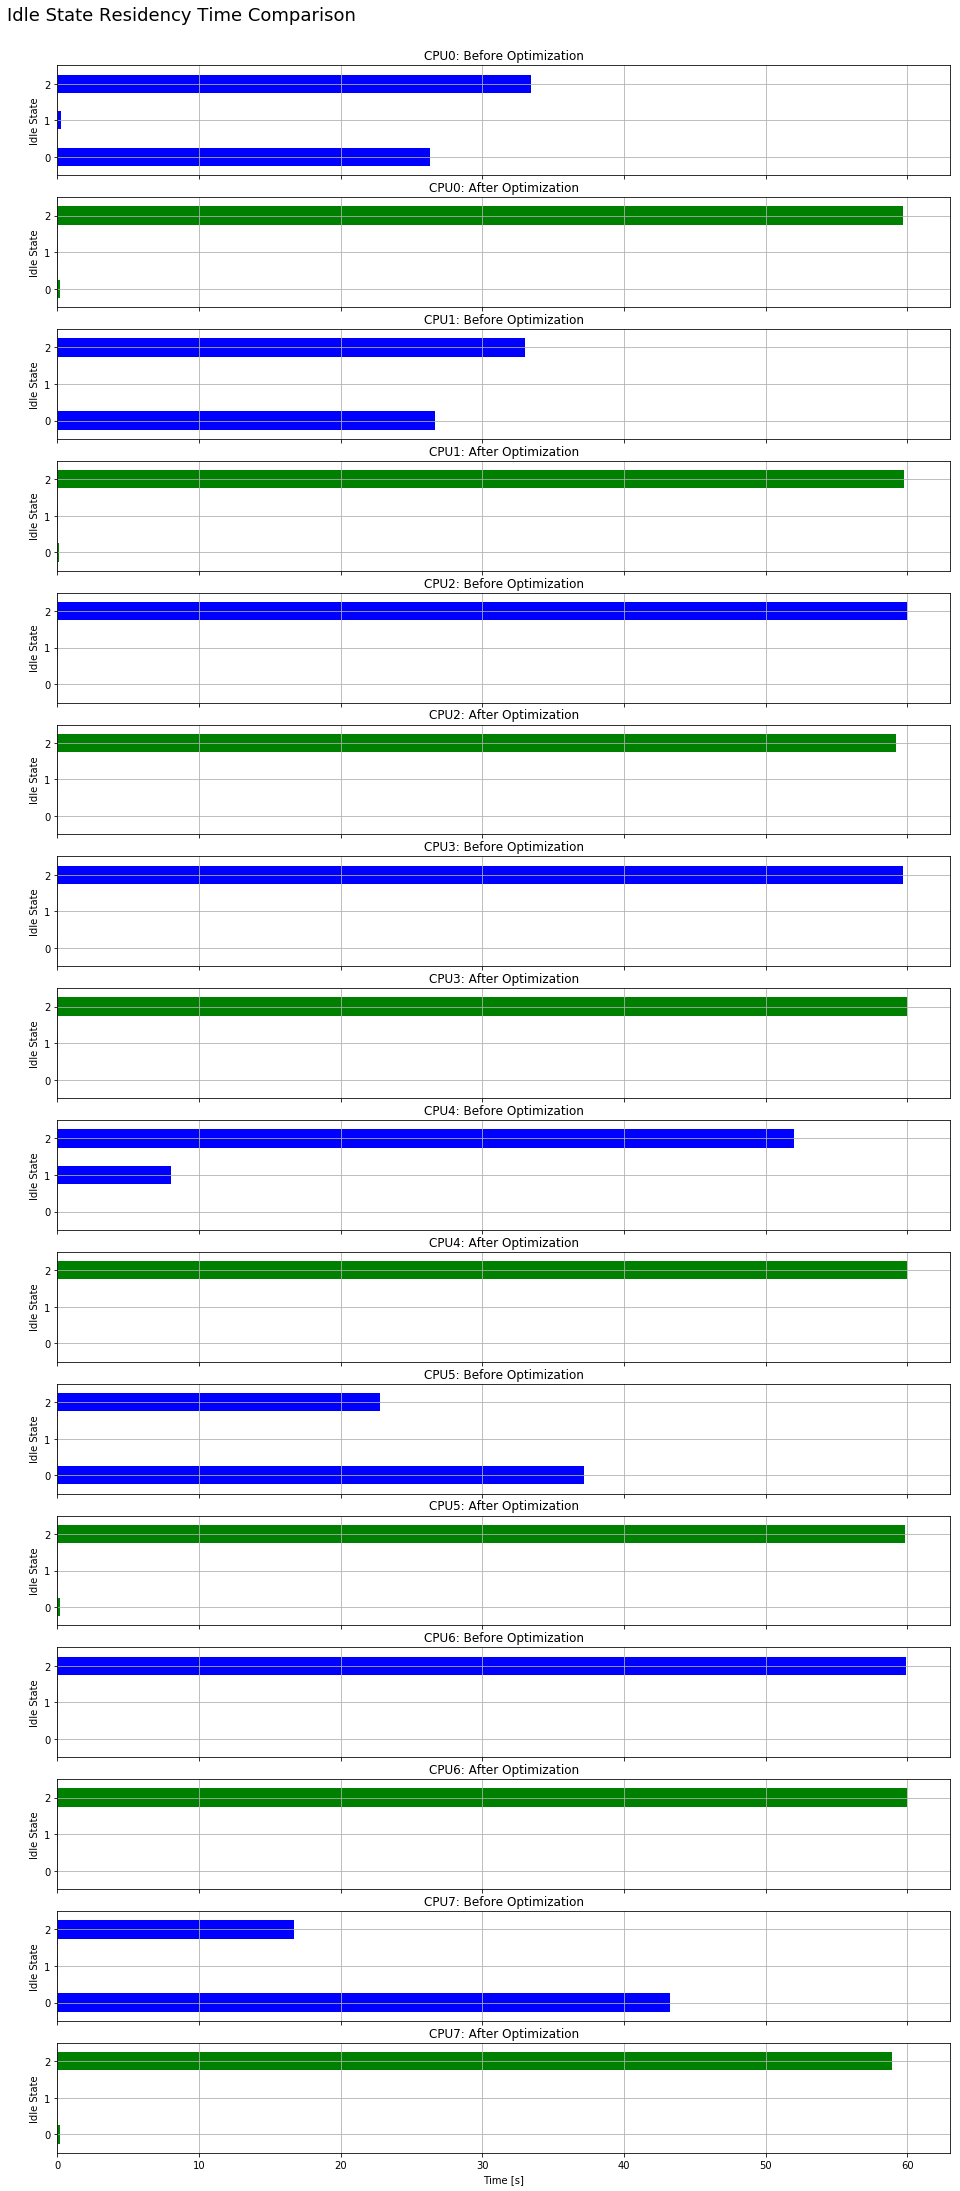

In [162]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [163]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),26.306209,0.257640,33.437085
1,CPU0(opt),0.176018,0.073155,59.723376
2,CPU0(delta),-26.130191,-0.184485,26.286291
3,CPU1(orig),26.672985,0.000000,33.031119
4,CPU1(opt),0.142790,0.058999,59.763389
5,CPU1(delta),-26.530195,0.058999,26.732270
6,CPU2(orig),0.006951,0.038756,59.945315
7,CPU2(opt),0.007959,0.042355,59.203853
8,CPU2(delta),0.001008,0.003599,-0.741462
9,CPU3(orig),0.079421,0.000171,59.685617


# Idle state statistics and comparison for rt-app video case

In [164]:
res_dir = '/home/leoy/Work2/Develop/wa-data/cpuidle_loop_rework_pre_opt_video/wk1-rt_app-1'
trace_file = os.path.join(res_dir, "trace.dat")

In [165]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [166]:
prev_ia = trace.analysis.idle

In [167]:
res_dir = '/home/leoy/Work2/Develop/wa-data/cpuidle_loop_rework_post_opt_video/wk1-rt_app-1'
trace_file = os.path.join(res_dir, "trace.dat")

In [168]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [169]:
post_ia = trace.analysis.idle

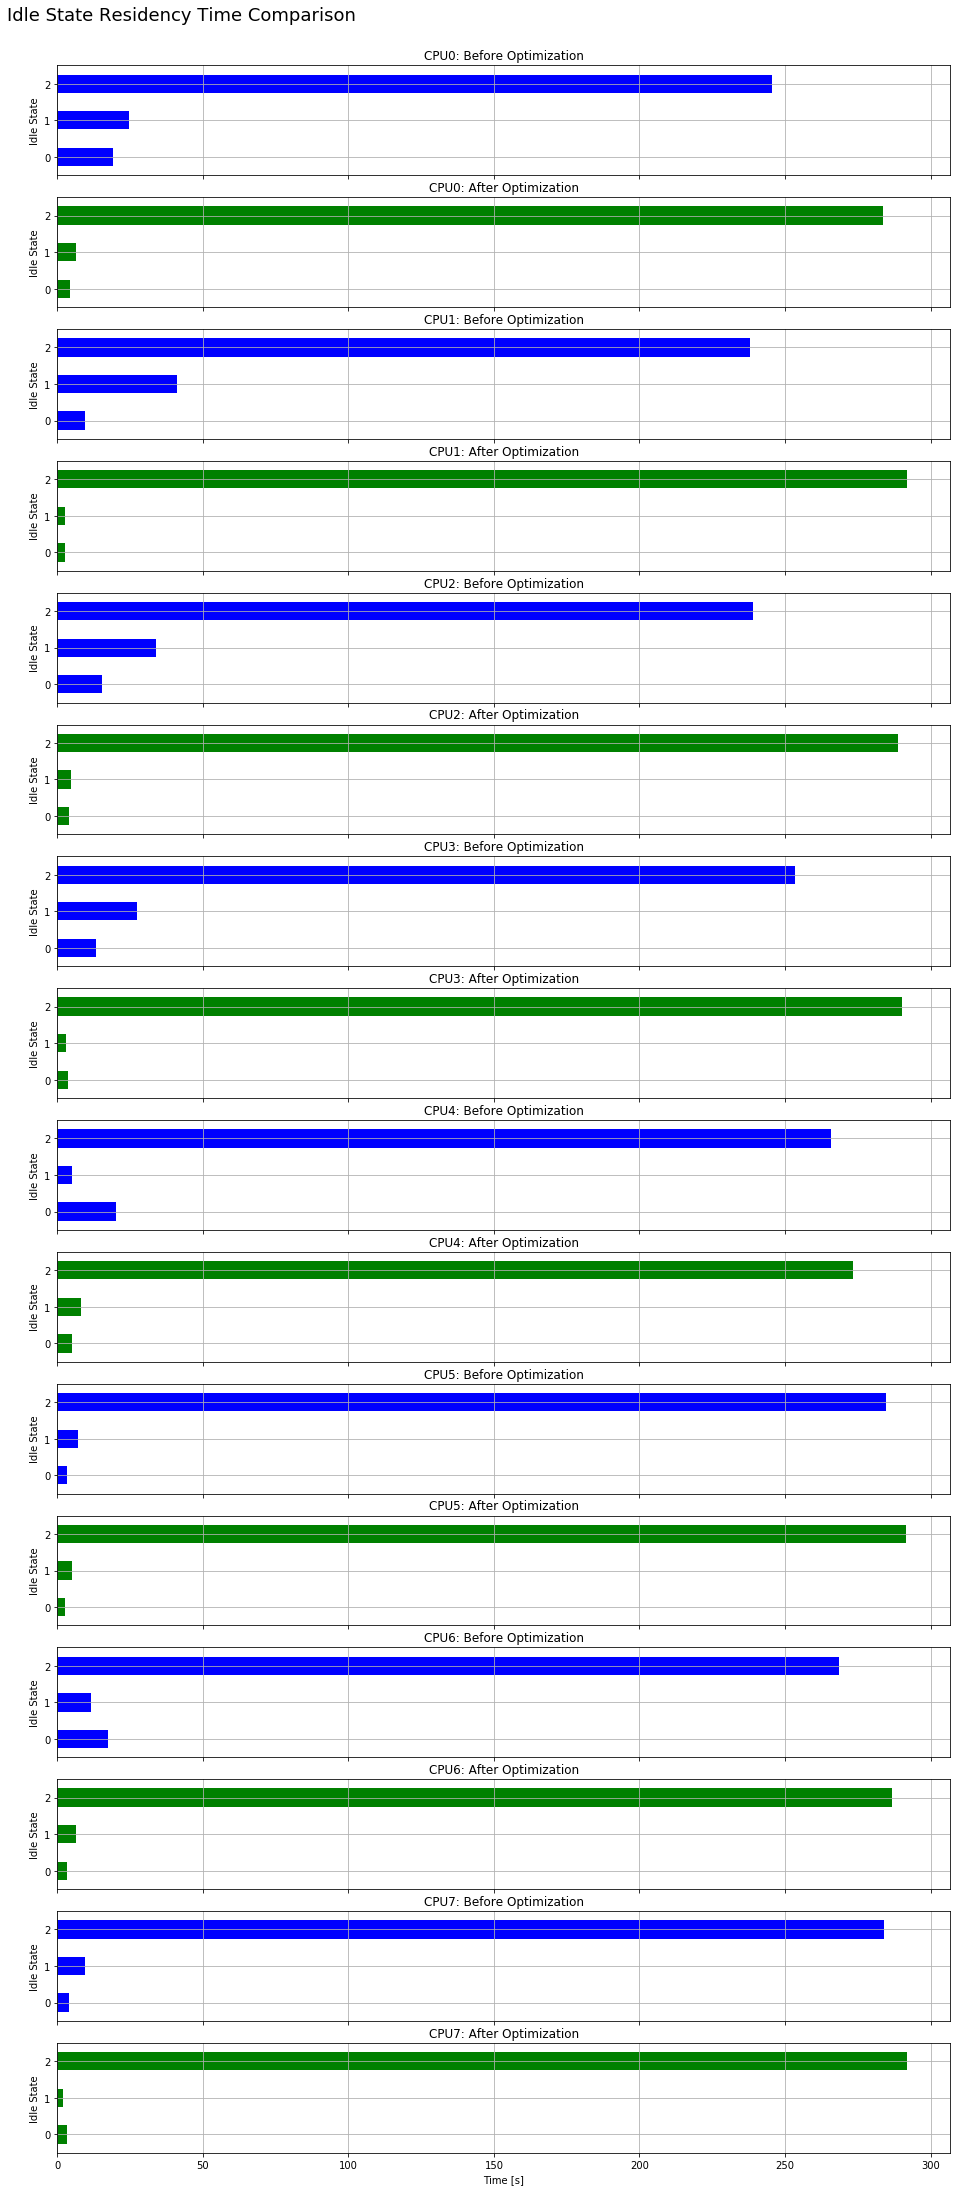

In [170]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [171]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),19.216752,24.535554,245.400615
1,CPU0(opt),4.355038,6.512938,283.748509
2,CPU0(delta),-14.861714,-18.022616,38.347894
3,CPU1(orig),9.684541,41.087236,237.964859
4,CPU1(opt),2.803859,2.593231,292.046794
5,CPU1(delta),-6.880682,-38.494005,54.081935
6,CPU2(orig),15.261803,33.862160,239.109379
7,CPU2(opt),4.101080,4.884871,288.679212
8,CPU2(delta),-11.160723,-28.977289,49.569833
9,CPU3(orig),13.379934,27.356345,253.385225
